In [898]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
from typing import Union, List
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from preprocessing import *
from feature_engineering import *



In [899]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [900]:
listings_raw = pd.read_csv("../data/raw/munich/2020-06-20/listings.csv.gz",compression="gzip")
#listings_raw = pd.read_csv("../data/raw/munich/2019-11-25/listings.csv.gz",compression="gzip")

listings_raw.shape

(11172, 106)

In [901]:
listings = listings_raw.copy()

In [902]:
# Mietspiegel Preise 2020 : https://www.wohnungsboerse.net/mietspiegel-Muenchen/2091
#del listings


In [903]:
# Format price
listings["price"] = format_price(listings["price"])
listings["cleaning_fee"] = format_price(listings["cleaning_fee"])
listings["cleaning_fee"] = listings["cleaning_fee"].fillna(0)
listings["extra_people"] = format_price(listings["extra_people"])

In [904]:
#listings = listings.loc[listings.price<=300]

(0, 200)

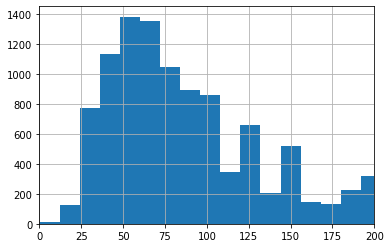

In [905]:
listings.price.hist(bins=1000)
plt.xlim(0,200)

In [906]:


# Drop outliers
def drop_outliers(listings, min_quantile=0.01, max_quantile=0.995):
    listings = listings[listings["price"] < listings["price"].quantile(max_quantile)]
    listings = listings[listings["price"] > listings["price"].quantile(min_quantile)]
    return listings

listings = drop_outliers(listings)

In [907]:
listings = listings[listings.price>0]
listings.price.min()

23.0

In [908]:
def text_contains_word(df: pd.DataFrame, search_features: Union[str, List[str]], word: Union[str,List[str]], feature_name: str) -> pd.DataFrame:
    """
    Checks if at least one of the given features contains a given word.

    Input:
    - df: pd.DataFrame
    - search_features: names of columns with text data
    - word: str or list of words to search in the features
    - feature_name: name of new feature

    Returns:
    - pd.DataFrame with a new column named after the given words and representing a true/false flag.
    """
    if isinstance(word, list):
        word = [w.lower() for w in word]
        search_term = "|".join(word) # pipe for "or"-search
    else:
        search_term = word.lower()

    df[search_features] = df[search_features].apply(lambda x: x.str.lower())
    df[feature_name] = df[search_features].apply(lambda x: any(x.str.contains(search_term) & x.notna()), axis=1)
    return df

In [909]:
def mean_price(df: pd.DataFrame, feature):
    """Get mean price grouped by the given feature."""
    return df.groupby(feature).price.mean(),df.groupby(feature).price.median(), df[feature].value_counts()

In [910]:
def format_flags(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Format t / f to boolean True and False
    """
    flags = {"t": True, "f": False, "nan": np.NaN}
    for col in columns:
        df[col] = df[col].replace(flags)
        df[col] = df[col].astype(bool)
    return df

In [911]:
def make_dummies(series: pd.Series, name: str, sep="|") -> pd.DataFrame:
    """
    Performs one-hot encoding and renames the resulting columns by prepending the name parameter to column names
    """
    dummies = series.str.get_dummies(sep=sep)
    dummies.columns = name + dummies.columns
    for col in dummies.columns:
        dummies[col] = dummies[col].astype(bool)
    return dummies

In [912]:
# Make description-based feature
words = ["roof top", "roof-top", "Dachterasse","Dachterrasse","roof terrace"]
descriptive_columns = ["space", "description"]
listings = text_contains_word(listings, descriptive_columns, words, "roof_top_terrace")
listings["roof_top_terrace"] = listings["roof_top_terrace"].astype(bool)

In [913]:
# Perform one-hot encoding for amenities
amenities = listings_raw.amenities.str.replace("[{""}]", "")\
                    .str.replace("\"", "")
amenities = make_dummies(amenities, name="amenities_",sep=",")
amenities["total_amount_amenities"] = amenities.sum(axis=1)

# Add (one-hot encoded) amenity features to dataset
listings = pd.concat([listings, amenities], axis=1)


In [914]:
# Convert host_since to number of month the host is active on AirBnB
listings["host_since_month"] = (pd.Timestamp("2020-07-01") - pd.to_datetime(listings["host_since"])).astype('timedelta64[M]')

In [915]:
# check if host lives in munich and thus at least nearby the AirBnb
listings = text_contains_word(listings, ["host_location"], ["Munich", "München"], "host_in_munich")


In [916]:
# since response time is an ordinal feature (the shorter the better) we encode the categories with integers
# unknown is worst -> 5
listings["response_time_unknown"] = listings["host_response_time"].isna()
response_time_encoding = {"within an hour": 1,
                          "within a few hours": 2,
                          "within a day": 3,
                          "a few days or more": 4,
                          "nan": 99999}
listings.host_response_time.replace(response_time_encoding, inplace=True)


In [917]:
# remove %-sign from features containing rates
listings["host_response_rate"] = listings["host_response_rate"].astype(str).str.replace("%","").astype(float)
listings["host_acceptance_rate"] = listings["host_acceptance_rate"].astype(str).str.replace("%","").astype(float)



In [918]:
listings["host_in_different_neighbourhood"] = listings["host_neighbourhood"] != listings["neighbourhood"]

In [919]:
neighbourhood_other = listings["host_neighbourhood"].value_counts()[listings["host_neighbourhood"].value_counts()<=20].index
host_neighbourhood = make_dummies(listings["host_neighbourhood"].replace(neighbourhood_other, "other"), name="host_neighbourhood_", sep=" - ")

neighbourhood = make_dummies(listings["neighbourhood"], name="neighbourhood_" , sep=" - ")

listings = pd.concat([listings, host_neighbourhood], axis=1)
listings = pd.concat([listings, neighbourhood], axis=1)

In [920]:
# Get flag columns and reformat 
flag_cols = listings.apply(lambda x: 'f' in x.dropna().unique() or 't' in x.dropna().unique()).loc[lambda x: x==True].index.values
listings = format_flags(listings, flag_cols)

In [921]:
# encode host verification
listings["host_verifications"] = listings["host_verifications"].str.replace("\[|\]|'| ","")#.str.get_dummies(sep=",", drop_first=True)#.sum().sort_values()
host_verification_encoding = make_dummies(listings["host_verifications"], name="", sep=",")
# build a group of encoded host verification with just a few samples
other = host_verification_encoding.sum().loc[lambda x: x<1000].index.values
host_verification_encoding["other"] = host_verification_encoding[other].any(axis=1)
host_verification_encoding.drop(columns=other, inplace=True)
host_verification_encoding.columns = "host_verification_" + host_verification_encoding.columns#

listings = pd.concat([listings, host_verification_encoding], axis=1)

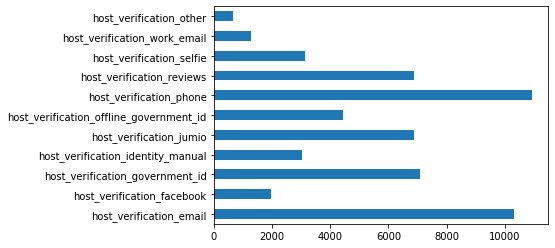

In [922]:
host_verification_encoding.sum().plot.barh()

In [923]:
listings["property_type"] = listings["property_type"].astype(str)

In [924]:
listings["property_type"] = listings["property_type"].replace({"Townhouse" : "House", "Bungalow": "House", 'Bungalow': 'House', 'Cottage': 'House','Villa': 'House', 'Tiny house': 'House', 'Earth house': 'House','Chalet': 'House',
 "Aparthotel": "Hotel", "Boutique hotel": "Hotel",
 "Serviced apartment" : "Apartment", "Condominium" : "Apartment", "Loft" : "Apartment"})

listings.loc[~listings["property_type"].isin(["House","Apartment","Hotel"]), "property_type"] = "Other"

In [925]:
# use zipcode directly as discrete variable since the codes provide information about how far away one zipcode is from another
listings["zipcode"] = listings["zipcode"].astype(str).str[:5] # make sure that the zipcode contains 5 digits
listings["zipcode"] = listings["zipcode"].astype(float)

In [926]:
#listings.room_type.value_counts(normalize=True)
room_type = make_dummies(listings["room_type"], name="room_type_")
listings = pd.concat([listings, room_type], axis=1)

In [927]:
#listings.bed_type.value_counts(normalize=True)
bed_type = make_dummies(listings["bed_type"], name="bed_type_")
listings = pd.concat([listings, bed_type], axis=1)

In [928]:
#listings.cancellation_policy.value_counts(normalize=True)
cancellation_policy = make_dummies(listings["cancellation_policy"], name="cancellation_policy_")
listings = pd.concat([listings, cancellation_policy], axis=1)

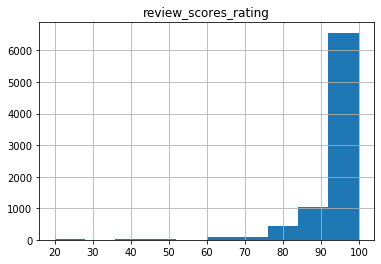

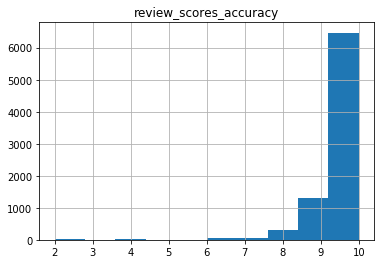

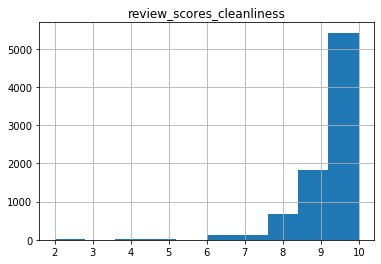

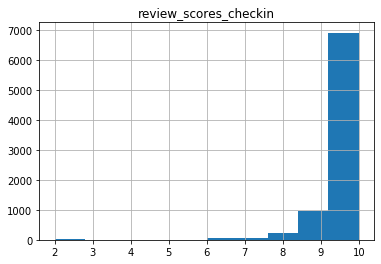

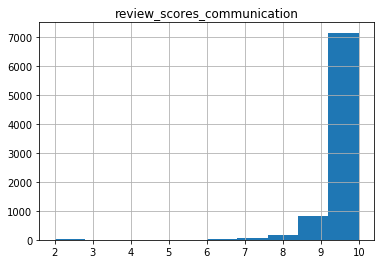

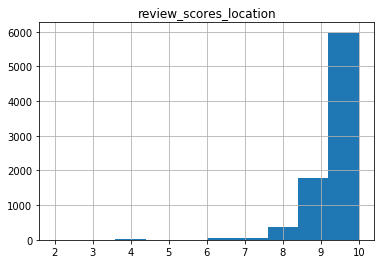

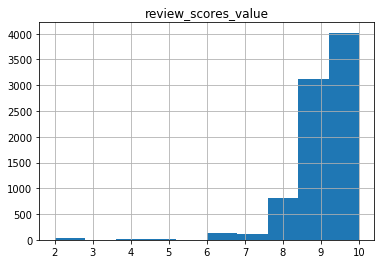

Index(['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')


In [824]:
for col in listings.columns[listings.columns.str.contains("score")]:
    listings[col].hist()
    plt.title(col)
    plt.show()
print(listings.columns[listings.columns.str.contains("score")])

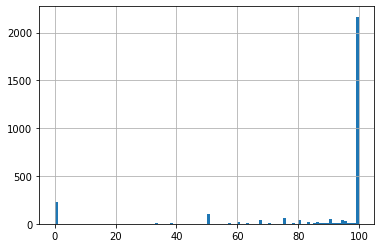

In [564]:
listings.host_response_rate.hist(bins=100)
#plt.xlim(85,100)

In [929]:
def make_bins(df, col, bins, labels, one_hot_encoded=False):
    """Bins the series into the given bins. The first bin starts with 0."""
    bins = pd.cut(df[col], bins=bins, include_lowest=True)
    if one_hot_encoded:
        categoricals = pd.get_dummies(bins).astype(bool)
        categoricals.columns = labels
        return categoricals
    return bins

def add_binning_features(listings):
    for col in ['review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value']:
        labels = [col + "_0-8", col + "_9", col + "_10"]
        bins = make_bins(listings, col, bins=[0,8,9,10], labels=labels, one_hot_encoded=True)
        listings = pd.concat([listings, bins], axis=1)

    col = "review_scores_rating"
    labels = [col + "_0-79", col + "_80-89", col + "_90-100"]    
    bins = make_bins(listings, col, bins=[0,80,90,100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)

    col = "host_response_rate"
    labels = [col + "_" + bin for bin in ["0-50","50-89", "90-99","100"]]
    bins = make_bins(listings, col, bins=[0, 50, 90, 99, 100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)

    col = "host_acceptance_rate"
    labels = [col + "_" + bin for bin in ["0-50","50-89", "90-99","100"]]
    bins = make_bins(listings, col, bins=[0, 50, 90, 99, 100], labels=labels, one_hot_encoded=True)
    listings = pd.concat([listings, bins], axis=1)

    return listings



In [931]:
listings = add_binning_features(listings)

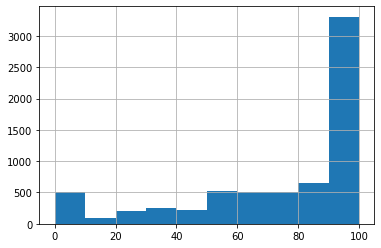

In [930]:
listings.host_acceptance_rate.hist()

In [932]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    See:
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-pointshttps://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def distance_to_point_of_interest(df):
    points_of_interest = {"oktoberfest_geo_location": (48.130910, 11.548901),
    "munich_main_station_geo_location": (48.140283, 11.560488),
    "munich_hofbraeuhaus_geo_location": (48.137612, 11.579911),
    "munich_englischer_garten_geo_location": ( 48.152066, 11.592246 ),
    "munich_deutsches_museum_geo_location": ( 48.129929, 11.583482 )}

    for poi, coords in points_of_interest.items():
        df[poi] = df.apply(lambda x: haversine(x["longitude"], x["latitude"], coords[1], coords[0]), axis=1)

    return df

In [933]:
listings = distance_to_point_of_interest(listings)

In [934]:
listings["average_poi_distance"] = listings.apply(lambda x: x[x.index.str.contains("geo_location")].mean(),axis=1)

In [935]:
listings = listings.dropna(subset=["latitude","longitude"])

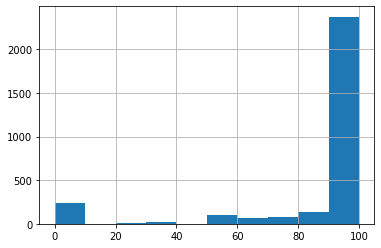

In [832]:
listings["host_response_rate"].hist()

In [936]:
# Drop columns with >50% NaNs
listings.drop(columns=(listings.isna().sum() / len(listings)).loc[lambda x: x>0.5].index.values, inplace=True)

In [937]:
# Remove features with only one observed value
listings.drop(columns=listings.apply(lambda x: x.nunique() <= 1).loc[lambda x: x==True].index.values, inplace=True)

In [938]:
listings["amount_white_goods"] = listings['amenities_Washer'].astype(int) + listings['amenities_Washer/Dryer'].astype(int) + listings['amenities_Dishwasher'].astype(int)
listings["amount_baby_equipment"] = listings['amenities_Changing table'].astype(int) + listings['amenities_Crib'].astype(int) + listings['amenities_High chair'].astype(int) + listings['amenities_Baby bath'].astype(int) + listings['amenities_Baby monitor'].astype(int) + listings['amenities_Babysitter recommendations'].astype(int)


listings["amenities_TV"] = listings['amenities_TV'] | listings['amenities_Cable TV'] | listings['amenities_Smart TV']
listings.drop(columns=['amenities_Cable TV', 'amenities_Smart TV'], inplace=True)

listings["amenities_Washer"] = listings['amenities_Washer'] | listings['amenities_Washer/Dryer']
listings.drop(columns=['amenities_Washer/Dryer'], inplace=True)

listings["amenities_Kitchen"] = listings['amenities_Kitchen'] | listings['amenities_Full kitchen'] | listings['amenities_Kitchenette']
listings.drop(columns=['amenities_Full kitchen', 'amenities_Kitchenette'], inplace=True)

listings["amenities_baby_equipment"] = listings['amenities_Changing table'] | listings['amenities_Crib'] | listings['amenities_High chair'] | listings['amenities_Baby bath'] | listings['amenities_Baby monitor'] | listings['amenities_Babysitter recommendations']
listings.drop(columns=['amenities_Changing table','amenities_Crib', 'amenities_High chair'], inplace=True)

listings["amenities_Pets live on this property"] = listings["amenities_Pets live on this property"] | listings['amenities_Dog(s)'] | listings['amenities_Cat(s)']
listings.drop(columns=['amenities_Dog(s)','amenities_Cat(s)'], inplace=True)


selected_amenities = [
'amenities_Air conditioning',
'amenities_BBQ grill',
'amenities_TV',
'amenities_Washer',
'amenities_Family/kid friendly',
'amenities_Kitchen',
'amenities_Garden or backyard',
'amenities_Gym',
'amenities_Laptop-friendly workspace',
'amenities_Patio or balcony',
'amenities_Wide entrance for guests','amenities_Elevator',
'amenities_Breakfast',
"amenities_Pets live on this property",
"amenities_baby_equipment",
"amount_baby_equipment"
"amount_white_goods"]

#amenities_Balcony





"""amenities_Bathtub

amenities_Carbon monoxide alarm
amenities_Indoor fireplace
amenities_Free street parking
amenities_Long term stays allowed
amenities_No stairs or steps to enter

amenities_Private entrance"""


'amenities_Bathtub\n\namenities_Carbon monoxide alarm\namenities_Indoor fireplace\namenities_Free street parking\namenities_Long term stays allowed\namenities_No stairs or steps to enter\n\namenities_Private entrance'

In [319]:
def plot_correlation_matrix(df):
    # Compute the correlation matrix
    corr = df.corr()
    print(corr.shape)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30,30))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


#plot_correlation_matrix(listings.loc[:,listings.columns[listings.columns.str.contains("amenities")]])

In [ ]:
#plot_correlation_matrix(listings.loc[:,listings.columns[listings.columns.str.contains("neighbourhood")&~listings.columns.str.contains("host")]])

In [713]:
def get_correlated_features(df, threshold=0.8):
    """
    """
    correlation_matrix = df.corr()
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        #corr_dict[correlation_matrix.columns[i]] = set()
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                if colname != correlation_matrix.index[j]:
                    correlated_features.add(colname)
    return correlated_features

#corr_f = filter_correlated_features(listings, 0.8)

In [939]:
correlated_neighbourhoods = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("neighbourhood")&~listings.columns.str.contains("host")]], 0.6)
correlated_neighbourhoods

{'neighbourhood_Fürstenried',
 'neighbourhood_Haidhausen',
 'neighbourhood_Hasenbergl',
 'neighbourhood_Hirschau',
 'neighbourhood_Landwied',
 'neighbourhood_Lehel',
 'neighbourhood_Lochhausen',
 'neighbourhood_Ludwigsvorstadt',
 'neighbourhood_Milbertshofen',
 'neighbourhood_München',
 'neighbourhood_Nymphenburg',
 'neighbourhood_Obersendling',
 'neighbourhood_Pasing',
 'neighbourhood_Ramersdorf',
 'neighbourhood_Solin',
 'neighbourhood_Thalkirchen',
 'neighbourhood_Trudering',
 'neighbourhood_Untergiesing',
 'neighbourhood_Untermenzing',
 'neighbourhood_West',
 'neighbourhood_Westpark'}

In [940]:
correlated_host_neighbourhoods = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("host_neighbourhood")]], 0.6)
correlated_host_neighbourhoods

{'host_neighbourhood_Fürstenried',
 'host_neighbourhood_Haidhausen',
 'host_neighbourhood_Hasenbergl',
 'host_neighbourhood_Hirschau',
 'host_neighbourhood_Landwied',
 'host_neighbourhood_Lehel',
 'host_neighbourhood_Lochhausen',
 'host_neighbourhood_Ludwigsvorstadt',
 'host_neighbourhood_München',
 'host_neighbourhood_Obersendling',
 'host_neighbourhood_Pasing',
 'host_neighbourhood_Ramersdorf',
 'host_neighbourhood_Solin',
 'host_neighbourhood_Thalkirchen',
 'host_neighbourhood_Trudering',
 'host_neighbourhood_Untergiesing',
 'host_neighbourhood_Untermenzing',
 'host_neighbourhood_West',
 'host_neighbourhood_Westpark'}

In [941]:
correlated_amenities = get_correlated_features(listings.loc[:,listings.columns[listings.columns.str.contains("amenities")&~listings.columns.str.contains("total")]], 0.6)
correlated_amenities

{'amenities_Accessible-height bed',
 'amenities_Accessible-height toilet',
 'amenities_Bathroom essentials',
 'amenities_Bedroom comforts',
 'amenities_Body soap',
 'amenities_Children’s dinnerware',
 'amenities_Cooking basics',
 'amenities_Dishes and silverware',
 'amenities_Dishwasher',
 'amenities_Espresso machine',
 'amenities_Extra pillows and blankets',
 'amenities_Extra space around bed',
 'amenities_Heated floors',
 'amenities_Heated towel rack',
 'amenities_No stairs or steps to enter',
 'amenities_Outdoor seating',
 'amenities_Oven',
 'amenities_Refrigerator',
 'amenities_Roll-in shower',
 'amenities_Self check-in',
 'amenities_Stove',
 'amenities_Terrace',
 'amenities_Toilet paper',
 'amenities_Trash can',
 'amenities_Walk-in shower',
 'amenities_Well-lit path to entrance',
 'amenities_Wide clearance to shower',
 'amenities_Wide doorway to guest bathroom',
 'amenities_Wide entrance',
 'amenities_Wide entrance for guests',
 'amenities_Wide entryway',
 'amenities_Wide hallways

In [942]:
correlated_rest = get_correlated_features(listings.loc[:,listings.columns[~listings.columns.str.contains("amenities")&~listings.columns.str.contains("neighbourhood")]], 0.8)
correlated_rest.remove('average_poi_distance')
correlated_rest

{'availability_60',
 'availability_90',
 'bed_type_Real Bed',
 'calculated_host_listings_count_entire_homes',
 'host_acceptance_rate_0-50',
 'host_response_rate_100',
 'host_since_month',
 'host_total_listings_count',
 'host_verification_jumio',
 'host_verification_selfie',
 'maximum_minimum_nights',
 'maximum_nights_avg_ntm',
 'minimum_minimum_nights',
 'minimum_nights_avg_ntm',
 'munich_deutsches_museum_geo_location',
 'munich_englischer_garten_geo_location',
 'munich_hofbraeuhaus_geo_location',
 'munich_main_station_geo_location',
 'review_scores_communication_10',
 'review_scores_location_10',
 'reviews_per_month',
 'room_type_Private room'}

In [943]:
listings.drop(columns=correlated_neighbourhoods, inplace=True)
listings.drop(columns=correlated_host_neighbourhoods, inplace=True)
listings.drop(columns=correlated_amenities, inplace=True)
listings.drop(columns=correlated_rest, inplace=True)

In [944]:
drop_cols = ['listing_url',
            'scrape_id',
            'last_scraped',
            'thumbnail_url', 
            'medium_url',
            'picture_url', 
            'xl_picture_url',
            'host_thumbnail_url', 
            'host_picture_url',
            'calendar_last_scraped',
            'name',
            'summary',
            'scrape_id',
            'country_code',
            'country',
            'amenities',
            'space',
            'description',
            'id',
            'neighborhood_overview',
            'notes',
            'transit',
            'experiences_offered',
            'host_since',
            'access', 
            'interaction',
            'house_rules',
            'host_id',
            'host_url',
            'host_name',
            'host_location',
            'host_about',
            'host_neighbourhood',
            'neighbourhood',
            'host_verifications',
            'street',
            'zipcode',
            'city',
            'market', 
            'smart_location',
            'property_type',
            'state',
            'weekly_price',
            'monthly_price',
            'security_deposit',
            #'cleaning_fee',
            #'extra_people',
            'calendar_updated',
            'first_review',
            'last_review',
            'bed_type',
            'room_type',
            'cancellation_policy',
            #'neighbourhood_cleansed',
            'license',
            'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'
            ]
listings.drop(columns=drop_cols, inplace=True, errors='ignore')

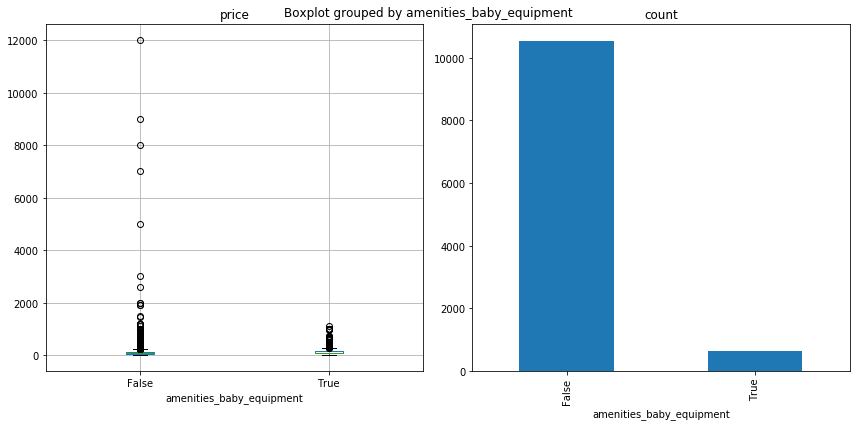

In [842]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
listings.boxplot(column="price", by='amenities_baby_equipment',ax=ax1, grid=True)
#sns.violinplot(x="amenities_Pets live on this property",y="price",data=listings, ax=ax1)
listings.groupby('amenities_baby_equipment').price.count().plot.bar(ax=ax2, title="count")
plt.tight_layout()
plt.show()

In [843]:
"""
for col in listings.columns[listings.columns.str.contains("amenities")][1:].values:
    fig, (ax1, ax2) = plt.subplots(1,2)
    listings.groupby(col).price.median().plot.bar(ax=ax1, title="price")
    listings.groupby(col).price.count().plot.bar(ax=ax2, title="count")
    plt.tight_layout()
    plt.show()"""

'\nfor col in listings.columns[listings.columns.str.contains("amenities")][1:].values:\n    fig, (ax1, ax2) = plt.subplots(1,2)\n    listings.groupby(col).price.median().plot.bar(ax=ax1, title="price")\n    listings.groupby(col).price.count().plot.bar(ax=ax2, title="count")\n    plt.tight_layout()\n    plt.show()'

In [945]:
amenities_to_drop = list(set(listings.columns[listings.columns.str.contains("amenities_")]) - set(selected_amenities))

In [946]:
def get_rare_binary_features(df, threshold):
    rare = []
    for col in df.columns:
        if ((df[col] == 1).sum() < threshold) or ((df[col] == 0).sum() < threshold) :
            rare.append(col)
    return rare

In [947]:
rare_features = get_rare_binary_features(listings[listings.columns[listings.columns.str.contains("amenities_")]], 50)
rare_features

['amenities_ toilet',
 'amenities_Air purifier',
 'amenities_Baby monitor',
 'amenities_Bath towel',
 'amenities_Beach essentials',
 'amenities_Beachfront',
 'amenities_Bread maker',
 'amenities_Disabled parking spot',
 'amenities_Doorman',
 'amenities_Fireplace guards',
 'amenities_Firm mattress',
 'amenities_Flat path to guest entrance',
 'amenities_Formal dining area',
 'amenities_Handheld shower head',
 'amenities_Hot water kettle',
 'amenities_Other pet(s)',
 'amenities_Ski-in/Ski-out',
 'amenities_Stair gates',
 'amenities_Table corner guards']

In [948]:
listings.drop(columns=rare_features, inplace=True)

In [58]:

#for col in listings.select_dtypes(np.number).columns:
#    listings[col].hist(bins=100, figsize=(12,12))
#    plt.title(col)
#    plt.show()

In [59]:
#for col in listings.drop(columns=["price"]).select_dtypes(np.number).columns:
#    np.log1p(listings[col]).hist(bins=100, figsize=(12,12))
#    plt.title(col)
#    plt.show()

In [949]:
listings["roof_top_terrace"] = listings["roof_top_terrace"].astype(bool)

In [950]:
listings = listings.drop(columns=amenities_to_drop, errors="ignore")

In [951]:
listings = listings.drop(columns=listings.columns[listings.columns.str.contains("host_neighbourhood")].values)

In [952]:
listings.drop(columns=['host_acceptance_rate'], inplace=True)

In [953]:
from scipy.special import boxcox, inv_boxcox

def prepare_date(X_train, X_test):
     # Create a imputer to replace missing values of numerical features with mean
    numeric_features = X_train.drop(columns=["price"]).select_dtypes(np.number).columns

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp = imp.fit(X_train[numeric_features])

    neighbourhood_mean_encoding = X_train.groupby("neighbourhood_cleansed")["price"].mean().to_dict()
    X_train["neighbourhood_mean_encoding"] = X_train["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)
    X_test["neighbourhood_mean_encoding"] = X_test["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)

    X_train = X_train.drop(columns = ["neighbourhood_cleansed", "price"])
    X_test = X_test.drop(columns = ["neighbourhood_cleansed", "price"])

    X_train[numeric_features] = imp.transform(X_train[numeric_features])
    X_test[numeric_features] = imp.transform(X_test[numeric_features])

    #X_train[numeric_features] = np.log1p(X_train[numeric_features])
    #X_test[numeric_features] = np.log1p(X_test[numeric_features])

    return X_train, X_test

"""
def train_models(X_train, y_train):
    lin_reg = LinearRegression().fit(X_train, y_train)
    rf_reg = RandomForestRegressor(n_estimators=800, max_depth=20, min_samples_leaf=5).fit(X_train, y_train)
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 6, alpha = 10, reg_lambda=2, n_estimators = 1200, n_jobs=6)
    xgb_reg.fit(X_train, y_train)

    return lin_reg, rf_reg, xgb_reg
"""

"\ndef train_models(X_train, y_train):\n    lin_reg = LinearRegression().fit(X_train, y_train)\n    rf_reg = RandomForestRegressor(n_estimators=800, max_depth=20, min_samples_leaf=5).fit(X_train, y_train)\n    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 6, alpha = 10, reg_lambda=2, n_estimators = 1200, n_jobs=6)\n    xgb_reg.fit(X_train, y_train)\n\n    return lin_reg, rf_reg, xgb_reg\n"

In [962]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    #pred_train = np.exp(model.predict(X_train))
    #pred_test = np.exp(model.predict(X_test))

    #pred_train = inv_boxcox(model.predict(X_train), fitted_lambda)
    #pred_test = inv_boxcox(model.predict(X_test), fitted_lambda)
    
    r2_train = r2_score(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    mse_train = mean_squared_error(y_train, pred_train)

    r2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mse_test = mean_squared_error(y_test, pred_test)

    fig, ax1, ax2 = plt.subplots(1,2)
    ax1.scatter(y_test, pred_test - y_test)
    ax1.set_ylabel("residual")
    ax1.set_xlabel("y_test")
    ax1.set_title("pred-true, r2="+str(r2_test))

    ax2.scatter(y_test, pred_test)
    ax2.set_ylabel("y_pred")
    ax2.set_xlabel("y_test")
    ax2.set_title("true vs pred, r2="+str(r2_test))
    plt.tight_layout()
    plt.show()

    return r2_train, mae_train, mse_train, r2_test, mae_test, mse_test

In [963]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
r2_train_scores = []
mae_train_scores = [] 
mse_train_scores = []

r2_test_scores = []
mae_test_scores = [] 
mse_test_scores = []
#listings = shuffle(listings)
for train_index, test_index in kf.split(listings, listings["price"]):
    X_train, X_test = listings.iloc[train_index], listings.iloc[test_index]
    y_train, y_test =  listings["price"].iloc[train_index], listings["price"].iloc[test_index]
    #y_train, y_test = np.log(y_train), np.log(y_test)
    #y_train, fitted_lambda = stats.boxcox(y_train) 
    #y_test = boxcox(y_test, fitted_lambda)

    X_train, X_test = prepare_date(X_train, X_test)
    xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.1, subsample=0.7, max_depth = 6, alpha = 15, reg_lambda=10, n_estimators = 1200, n_jobs=6)
    xgb_reg.fit(X_train, y_train)

    r2_train, mae_train, mse_train, r2_test, mae_test, mse_test = evaluate_model(xgb_reg, X_train, X_test, y_train, y_test)
    #r2_train, mae_train, mse_train, r2_test, mae_test, mse_test = evaluate_model(xgb_reg, X_train, X_test, np.exp(y_train), np.exp(y_test))
    #r2_train, mae_train, mse_train, r2_test, mae_test, mse_test = evaluate_model(xgb_reg, X_train, X_test, inv_boxcox(y_train, fitted_lambda), y_test, fitted_lambda)

    r2_train_scores.append(r2_train)
    mae_train_scores.append(mae_train)
    mse_train_scores.append(mse_train)

    r2_test_scores.append(r2_test)
    mae_test_scores.append(mae_test)
    mse_test_scores.append(mse_test)

    

ValueError: Illegal argument(s) to subplot: (1, 2)

In [ ]:
print("r2 on training set")
print(r2_train_scores)
print("r2 on test set")
print(r2_test_scores)
print("r2 mean on training set")
print(np.mean(r2_train_scores))
print("r2 mean on test set")
print(np.mean(r2_test_scores))

In [ ]:
print("mae on training set")
print(mae_train_scores)
print("mae on test set")
print(mae_test_scores)
print("mae mean on training set")
print(np.mean(mae_train_scores))
print("mae mean on test set")
print(np.mean(mae_test_scores))

In [2243]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

listings = shuffle(listings)

X_train, X_test, y_train, y_test = train_test_split(listings, listings["price"], test_size=0.15, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(listings[features[:20]], listings["price"], test_size=0.25, random_state=42)

In [2244]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb


# Create a imputer to replace missing values of numerical features with mean
numeric_features = X_train.drop(columns=["price"]).select_dtypes(np.number).columns
#numeric_features = X_train.select_dtypes(np.number).columns

#numeric_features = listings[features[:20]].select_dtypes(np.number).columns
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp = KNNImputer(n_neighbors=3, weights="uniform")#
imp = imp.fit(X_train[numeric_features])

neighbourhood_mean_encoding = X_train.groupby("neighbourhood_cleansed")["price"].mean().to_dict()
X_train["neighbourhood_mean_encoding"] = X_train["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)
X_test["neighbourhood_mean_encoding"] = X_test["neighbourhood_cleansed"].map(neighbourhood_mean_encoding)

X_train = X_train.drop(columns = ["neighbourhood_cleansed", "price"])
X_test = X_test.drop(columns = ["neighbourhood_cleansed", "price"])

X_train[numeric_features] = imp.transform(X_train[numeric_features])
X_test[numeric_features] = imp.transform(X_test[numeric_features])

lin_reg = LinearRegression().fit(X_train, y_train)
rf_reg = RandomForestRegressor(n_estimators=800, max_depth=20, min_samples_leaf=3, n_jobs=-1).fit(X_train, y_train)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 6, alpha = 10, reg_lambda=2, n_estimators = 1200, n_jobs=6)
xgb_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1200, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [2245]:
lin_y_pred = lin_reg.predict(X_test)
print("Linear Regression")
print("R2: {}".format(r2_score(y_test, lin_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, lin_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, lin_y_pred)))

rf_y_pred = rf_reg.predict(X_test)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_test, rf_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, rf_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, rf_y_pred)))

xgb_y_pred = xgb_reg.predict(X_test)
print("XGB Regression")
print("R2: {}".format(r2_score(y_test, xgb_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, xgb_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, xgb_y_pred)))
"""
lin_y_pred = lin_reg.predict(X_test)
print("Linear Regression")
print("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(lin_y_pred))))
print("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(lin_y_pred))))
print("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(lin_y_pred))))

rf_y_pred = rf_reg.predict(X_test)
print("Random Forest Regression")
print("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(rf_y_pred))))
print("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(rf_y_pred))))
print("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(rf_y_pred))))"""

Linear Regression
R2: 0.2219285538152439
MAE: 29.51493853028306
MSE: 1411.871032948308
Random Forest Regression
R2: 0.35954791739438274
MAE: 26.546627391906267
MSE: 1162.1500157294986
XGB Regression
R2: 0.38565715630223085
MAE: 25.690814971923828
MSE: 1114.7728271484375


'\nlin_y_pred = lin_reg.predict(X_test)\nprint("Linear Regression")\nprint("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(lin_y_pred))))\nprint("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(lin_y_pred))))\nprint("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(lin_y_pred))))\n\nrf_y_pred = rf_reg.predict(X_test)\nprint("Random Forest Regression")\nprint("R2: {}".format(r2_score(np.expm1(y_test), np.expm1(rf_y_pred))))\nprint("MAE: {}".format(mean_absolute_error(np.expm1(y_test), np.expm1(rf_y_pred))))\nprint("MSE: {}".format(mean_squared_error(np.expm1(y_test), np.expm1(rf_y_pred))))'

In [2246]:
rf_y_pred2 = rf_reg.predict(X_train)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_train, rf_y_pred2)))
print("MAE: {}".format(mean_absolute_error(y_train, rf_y_pred2)))
print("MSE: {}".format(mean_squared_error(y_train, rf_y_pred2)))

xgb_y_pred2 = xgb_reg.predict(X_train)
print("XGB Regression")
print("R2: {}".format(r2_score(y_train, xgb_y_pred2)))
print("MAE: {}".format(mean_absolute_error(y_train, xgb_y_pred2)))
print("MSE: {}".format(mean_squared_error(y_train, xgb_y_pred2)))

Random Forest Regression
R2: 0.8169425664256819
MAE: 13.03956438363102
MSE: 300.85648734374007
XGB Regression
R2: 0.6181024626066516
MAE: 19.094253540039062
MSE: 627.65185546875


In [ ]:
import seaborn as sns
sns.regplot(x=y_test, y=rf_y_pred, marker="+")
plt.show()
sns.regplot(x=y_test, y=xgb_y_pred, marker="+")
plt.show()

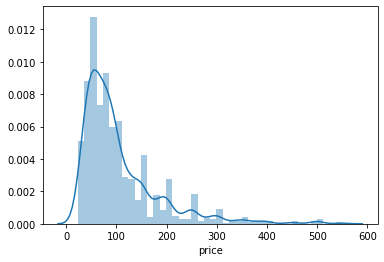

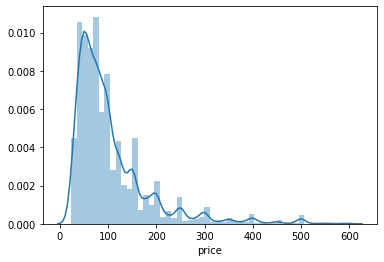

In [1769]:
sns.distplot(y_test)
plt.show()
sns.distplot(y_train)
plt.show()

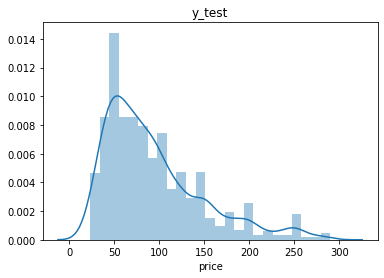

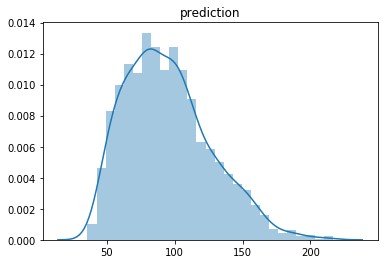

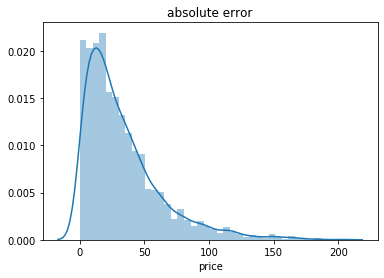

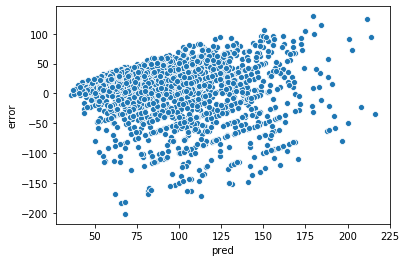

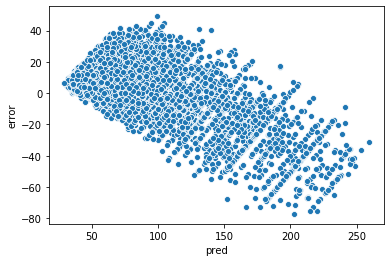

In [368]:
sns.distplot(y_test)
plt.title("y_test")
plt.show()
sns.distplot(rf_y_pred)
plt.title("prediction")
plt.show()
sns.distplot(abs(rf_y_pred-y_test))
plt.title("absolute error")
plt.show()
sns.scatterplot(x=rf_y_pred, y=rf_y_pred-y_test)
plt.xlabel("pred")
plt.ylabel("error")
plt.show()
sns.scatterplot(x=rf_reg.predict(X_train), y=rf_reg.predict(X_train)-y_train)
plt.xlabel("pred")
plt.ylabel("error")
plt.show()

In [863]:
# First train a dummy regressor as most trivial baseline model -> uses mean price of training data as prediction for all airbnbs in the test dataset
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_y_pred = dummy_regr.predict(X_test)
print("Dummy Regression")
print("R2: {}".format(r2_score(y_test, dummy_y_pred)))
print("MAE: {}".format(mean_absolute_error(y_test, dummy_y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, dummy_y_pred)))


Dummy Regression
R2: -0.00011839766231158677
MAE: 0.5325536131858826
MSE: 0.44348815083503723


In [345]:
# Sort the importance of the features
importances = rf_reg.feature_importances_
    
values = sorted(zip(X_train.columns, rf_reg.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:70]
y_feature = np.arange(len(features))
score = feature_importances['score'][:70]

# Plot the importance of a feature to the price
plt.figure(figsize=(20,10));
plt.bar(y_feature, score, align='center');
plt.xticks(y_feature, features, rotation='vertical');
plt.xlabel('Features');
plt.ylabel('Score');
plt.title('Importance of features (TOP 50)');

NameError: name 'rf_reg' is not defined

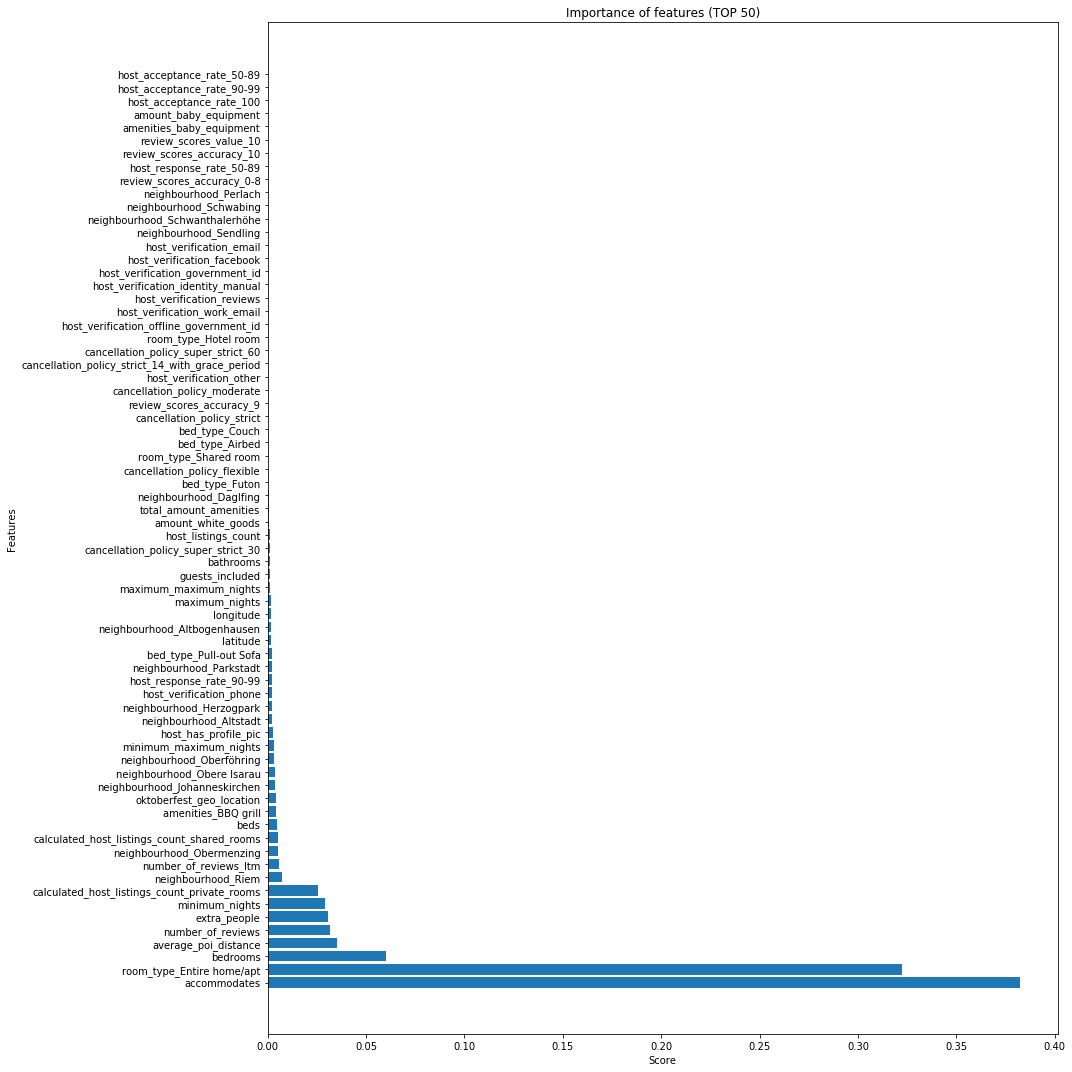

In [888]:
# Sort the importance of the features
importances = xgb_reg.feature_importances_
    
values = sorted(zip(X_train.columns, xgb_reg.feature_importances_), key=lambda x: x[1] * -1)
feature_importances = pd.DataFrame(values, columns = ["feature", "score"])
feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

features = feature_importances['feature'][:70]
y_feature = np.arange(len(features))
score = feature_importances['score'][:70]

# Plot the importance of a feature to the price
plt.figure(figsize=(15,15));
plt.barh(y_feature, score);
plt.yticks(y_feature, features);
plt.ylabel('Features');
plt.xlabel('Score');
plt.title('Importance of features (TOP 50)');
plt.tight_layout()
plt.show()

In [371]:
import shap


In [372]:
reg

NameError: name 'reg' is not defined

In [83]:
subset = shuffle(pd.concat([X_train, X_test]))[:100]

In [84]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(subset)


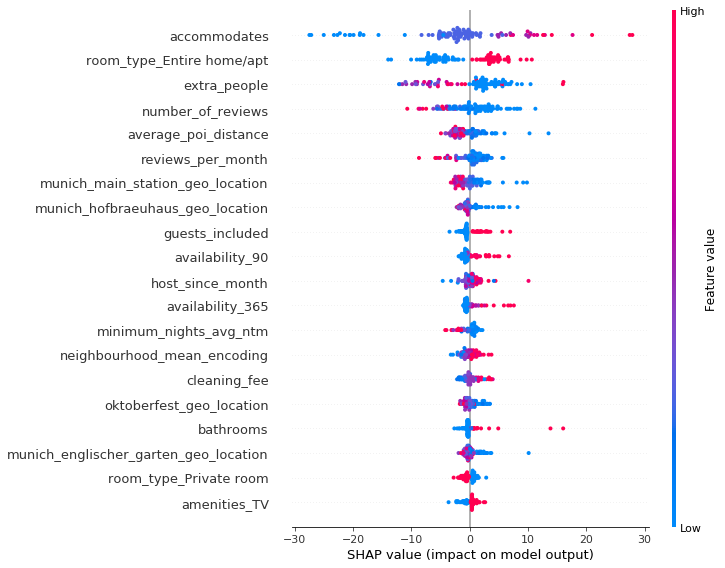

In [85]:
shap.summary_plot(shap_values, subset)

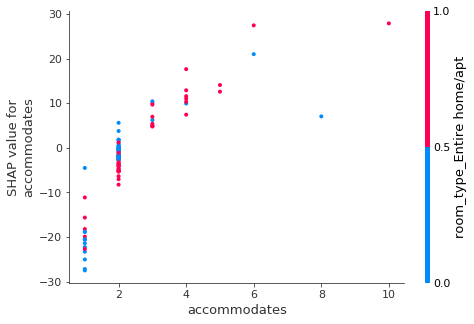

In [86]:
shap.dependence_plot("accommodates", shap_values, subset)

In [91]:
shap.force_plot(shap_va)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [87]:
y_pred = reg.predict(X_train)
print("Random Forest Regression")
print("R2: {}".format(r2_score(y_train, y_pred)))
print("MAE: {}".format(mean_absolute_error(y_train, y_pred)))

Random Forest Regression
R2: 0.8945220204069843
MAE: 10.290993689269886
